[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jonis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\jonis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jonis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saved cleaned + sentiment dataset with 1377 rows to reddit_data_sentiment.csv

Sentiment distribution:
sentiment
positive    930
negative    268
neutral     179
Name: count, dtype: int64

Top words in negative mentions (after stopword removal):
        word  count
0      linux    232
1    windows    145
2        use    107
3       dont     94
4         im     81
5       time     79
6       like     78
7        one     77
8       work     72
9      would     71
10       get     64
11       new     64
12      need     62
13      even     62
14     using     60
15    system     57
16    people     56
17  firewall     54
18      know     52
19       ive     49

Top bigrams in negative mentions:
                  bigram  count
0        (invalid, user)     18
1       (upload, speeds)     17
2   (connection, closed)     11
3      (closed, invalid)     11
4        (port, preauth)     11
5        (linux, distro)      9
6    (operating, system)      9
7          (dont, think)      9
8        (li

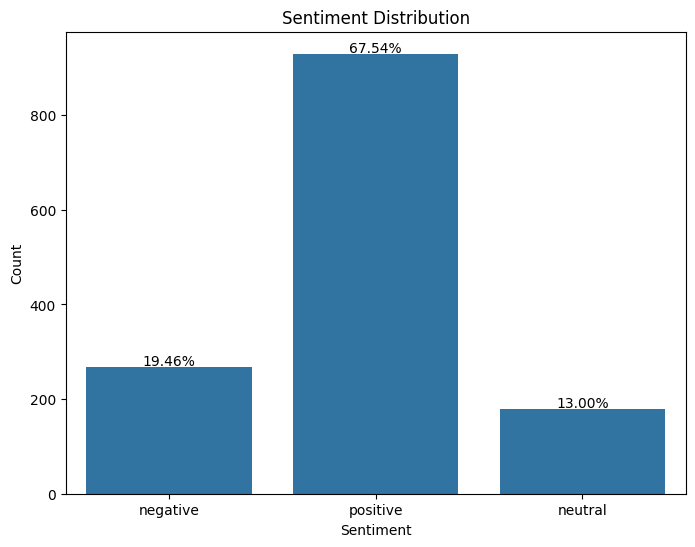

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import word_tokenize, bigrams
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
import nltk


# -----------------------------
# Setup
# -----------------------------
nltk.download("vader_lexicon")
nltk.download("punkt")
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))
sia = SentimentIntensityAnalyzer()

# -----------------------------
# Load dataset
# -----------------------------
df_clean = pd.read_csv("reddit_data_clean.csv")

# -----------------------------
# Fix: remove literal "nan" word, not drop rows
# -----------------------------
def clean_nan_words(text):
    text = str(text).lower()
    text = text.replace("nan ", "").replace(" nan", "").strip()
    return text

df_clean["clean_text"] = df_clean["clean_text"].apply(clean_nan_words)

# -----------------------------
# Sentiment Analysis
# -----------------------------
def get_sentiment(text):
    score = sia.polarity_scores(str(text))["compound"]
    if score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    else:
        return "neutral"

df_clean["sentiment"] = df_clean["clean_text"].apply(get_sentiment)

# -----------------------------
# Stopword cleanup for pain points
# -----------------------------
def preprocess_for_painpoints(text):
    tokens = word_tokenize(str(text).lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return tokens

df_clean["tokens"] = df_clean["clean_text"].apply(preprocess_for_painpoints)

# -----------------------------
# Pain point extraction (negative posts only)
# -----------------------------
negative_texts = df_clean[df_clean["sentiment"] == "negative"]

# Unigrams
all_unigrams = [tok for tokens in negative_texts["tokens"] for tok in tokens]
unigram_counts = Counter(all_unigrams).most_common(20)

# Bigrams
all_bigrams = [bg for tokens in negative_texts["tokens"] for bg in bigrams(tokens)]
bigram_counts = Counter(all_bigrams).most_common(20)


columns_to_keep = ["id", "category", "subreddit", "full_text", 
                   "keywords_found", "clean_text", "sentiment"]

df_final = df_clean[columns_to_keep].copy()
df_final.to_csv("reddit_data_sentiment.csv", index=False)

print(f"Saved cleaned + sentiment dataset with {len(df_final)} rows to reddit_data_sentiment.csv")

# -----------------------------
# Summary Outputs
# -----------------------------
print("\nSentiment distribution:")
print(df_final["sentiment"].value_counts())

print("\nTop words in negative mentions (after stopword removal):")
print(pd.DataFrame(unigram_counts, columns=["word", "count"]))

print("\nTop bigrams in negative mentions:")
print(pd.DataFrame(bigram_counts, columns=["bigram", "count"]))

# Sentiment Distribution Plot with percentages
plt.figure(figsize=(8,6))
sns.countplot(data=df_final, x="sentiment")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2, height + 3, f"{height / len(df_final) * 100:.2f}%", ha="center")
plt.show()

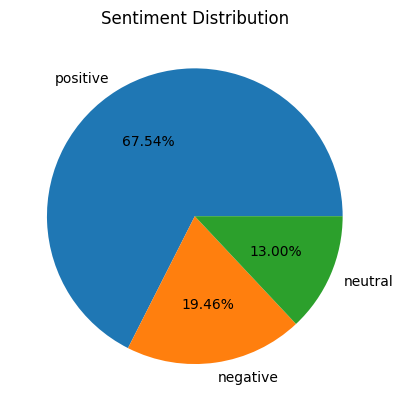

In [3]:
# Sentiment Distribution Pie Chart
df_final["sentiment"].value_counts().plot(kind="pie", autopct='%1.2f%%')
plt.title("Sentiment Distribution")
plt.ylabel("")
plt.show()

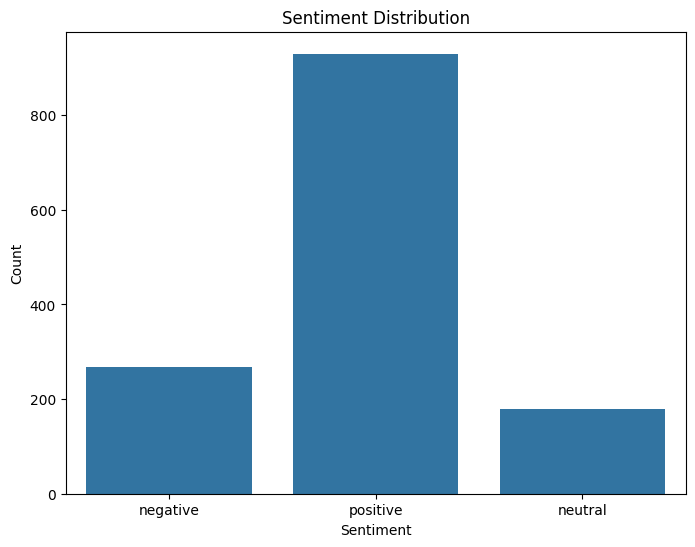

In [4]:
# Sentiment Distribution Plot
plt.figure(figsize=(8,6))
sns.countplot(data=df_final, x="sentiment")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()